## 1. Importing Libraries

In [16]:
import os
import datetime
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow_probability as tfp
from tensorflow.keras.metrics import SparseCategoricalAccuracy, Mean
from tensorflow.keras.utils import Progbar
from tensorflow.keras.datasets import mnist
import uncertainty_wizard as uwiz
import matplotlib.pyplot as plt
from uncertainty_wizard.models.stochastic_utils.layers import UwizBernoulliDropout, UwizGaussianDropout, UwizGaussianNoise
from uncertainty_wizard.models._stochastic._stochastic_mode import StochasticMode
import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix, classification_report
from cleverhans.tf2.attacks.fast_gradient_method import fast_gradient_method
from cleverhans.tf2.attacks.projected_gradient_descent import projected_gradient_descent
import seaborn as sns

## Check GPU

In [3]:
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    print(f'Number og GPUs Available: {len(gpus)}')
    for gpu in gpus:
        print('Name:', gpu.name, 'Type:', gpu.device_type)
else:
    print('No GPUs found. Please check your TensorFlow installation and GPU setup')

Number og GPUs Available: 1
Name: /physical_device:GPU:0 Type: GPU


## 2. Load and preprocess MNIST

In [6]:
# Load mnist data 
(x_train, y_train), (x_test, y_test) = mnist.load_data()

# Lenght of training samples
print('Lenght of training samples: ', len(x_train))

# Lenght of test samples
print('\nLenght of test samples: ', len(x_test))

# Shape 
print('\nShape: ', x_train[0].shape)
print('\n-----------------------------------------------------------------')

# Preprocess the data
x_train = (x_train.astype('float32') / 255).reshape(x_train.shape[0], 28, 28, 1)
x_test = (x_test.astype('float32') / 255).reshape(x_test.shape[0], 28, 28, 1)


y_train = tf.keras.utils.to_categorical(y_train, num_classes=10)
y_test = tf.keras.utils.to_categorical(y_test, num_classes=10)


def create_stochastic_model():
    model = uwiz.models.StochasticSequential()
    model.add(tf.keras.layers.Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(28, 28, 1)))
    model.add(tf.keras.layers.Conv2D(64, (3, 3), activation='relu'))
    model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))
    model.add(UwizBernoulliDropout(0.5, stochastic_mode=StochasticMode()))
    model.add(tf.keras.layers.Flatten())
    model.add(tf.keras.layers.Dense(128, activation='relu'))
    model.add(tf.keras.layers.Dense(10, activation='softmax'))
    
    model.compile(loss=tf.keras.losses.categorical_crossentropy,
                  optimizer=tf.keras.optimizers.legacy.Adam(),
                  metrics=['accuracy'])

    return model



# plot 4 images as gray scale
#plt.subplot(141)
#plt.imshow(x_train[0])
#plt.subplot(142)
#plt.imshow(x_train[1])
#plt.subplot(143)
#plt.imshow(x_train[2])
#plt.subplot(144)
#plt.imshow(x_train[3])
#plt.show()

Lenght of training samples:  60000

Lenght of test samples:  10000

Shape:  (28, 28)

-----------------------------------------------------------------


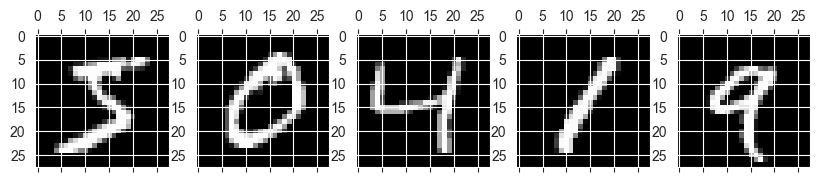

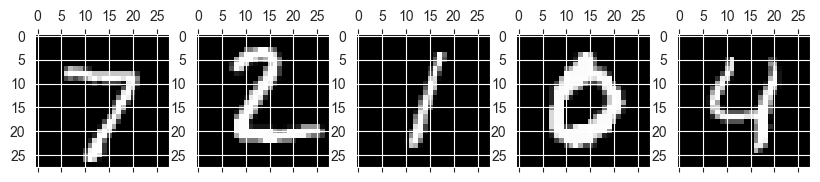

In [7]:


num_images = 5

fig = plt.figure(figsize=(10, 2.5))
for i in range(num_images):
    ax = fig.add_subplot(1, num_images, i+1)
    ax.matshow(x_train[i].squeeze(), cmap='gray')
    
plt.show()

fig2 = plt.figure(figsize=(10, 2.5))
for i in range(num_images):
    ax = fig2.add_subplot(1, num_images, i+1)
    ax.matshow(x_test[i].squeeze(), cmap='gray')
    
plt.show()


## 3. Train



In [8]:
model = create_stochastic_model()

history = model.fit(x_train, y_train,
                    validation_split=0.1,
                    batch_size=2000,
                    epochs=10,
                    verbose=1,
                    callbacks=[tf.keras.callbacks.EarlyStopping(patience=3),
                               tf.keras.callbacks.TensorBoard(log_dir='data/logs', histogram_freq=1)])

# Save the model
os.makedirs(os.path.dirname('data/model/'), exist_ok=True)
model.inner.save_weights('data/model/clean_model_weights.h5')
print("\nTraining completed, model weights saved")

2024-02-23 21:38:47.299733: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1 Pro
2024-02-23 21:38:47.299760: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 32.00 GB
2024-02-23 21:38:47.299767: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 10.67 GB
2024-02-23 21:38:47.299839: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-02-23 21:38:47.299884: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)
/opt/homebrew/lib/python3.11/site-packages/uncertainty_wizard/models/stochastic_utils/layers.py:25: UncertaintyWizardWarning: Looks like you are passing an <class 'uncertainty_wizar

Epoch 1/10


2024-02-23 21:38:47.772572: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


27/27 [==============================] - 3s 89ms/step - loss: 0.7190 - accuracy: 0.7880 - val_loss: 0.2174 - val_accuracy: 0.9363
Epoch 2/10
27/27 [==============================] - 2s 83ms/step - loss: 0.2251 - accuracy: 0.9344 - val_loss: 0.1149 - val_accuracy: 0.9692
Epoch 3/10
27/27 [==============================] - 2s 83ms/step - loss: 0.1309 - accuracy: 0.9615 - val_loss: 0.0784 - val_accuracy: 0.9800
Epoch 4/10
27/27 [==============================] - 2s 83ms/step - loss: 0.0936 - accuracy: 0.9720 - val_loss: 0.0651 - val_accuracy: 0.9832
Epoch 5/10
27/27 [==============================] - 2s 83ms/step - loss: 0.0769 - accuracy: 0.9767 - val_loss: 0.0581 - val_accuracy: 0.9845
Epoch 6/10
27/27 [==============================] - 2s 83ms/step - loss: 0.0689 - accuracy: 0.9794 - val_loss: 0.0537 - val_accuracy: 0.9862
Epoch 7/10
27/27 [==============================] - 2s 83ms/step - loss: 0.0615 - accuracy: 0.9811 - val_loss: 0.0519 - val_accuracy: 0.9860
Epoch 8/10
27/27 [======

# Adversarial Training

Purpose of the adversarial training is to enhance the model's robustness by training it on both clean and adversarially perturbed data. The idea is to make the model learn to generalize well even under adversarial conditions. 

 Process during adversarial training is that we generate adversarial examples using methods like **Projected Gradient Descent (PGD) and then train the model on these examples. Tis is meant to simulate potential attacks and teach the model to recognize and correctly classify both unaltered and altered inputs.

The loss function in the adversarial training setup (CategoricalCrossentropy(from_logits=True)) expects logits (i.e., the model's raw output before the softmax layer) as inputs. If the model ends with a softmax layer, this could mislead the training process.

Solution: Ensure that the model's output is compatible with the loss function's expectations. If the model ends with a softmax activation, we need to set from_logits=False or remove the softmax layer and handle the activation externally.

## Cleverhans tutorial

#### Fast Gradient Sign Method (FGSM)

FGSM is one of the simplest and fastest methods to generate adversarial examples. It perturbs each input by a small amount in the direction of the gradient of the loss with respect to the input.

- `eps` (epsilon) parameter controls the magnitude of the perturbation added to the input images. It defines the step size in the direction of the loss gradient and essentially controls the strength of the attack. Smaller values of `eps` generate adversarial examples that are closer to the orginal inputs, while larger values of `eps` may result in more noticeable perturbations.
- `clip_min`and `clip_max` parameters define the minimum and maximum values that any component of the input tensor can take. They are used to clip the adversarial images to ensure they remain valid images. For example, for images with pixel values in the range [0,1], you would set `clip_min=0` and `clip_max=1`.
- `norm` parameter defines the norm of the perturbations. It's not directly used in FGSM in CleverHans but is relevant for methods that require specifying the norm type for perturbations (like PGD)

#### Projected Gradient Descent (PGD)

PGD is more powerful attack compared to FGSM, iterating multiple times to find more effective adversarial examples within a specified perturbation budget.

**Parameters**:
- `eps`; similar to FGSM, it controls the maximum perturbation that can be added to the input images. It defines the "budget" within which the adversarial examples can be crafted. 
- `eps_iter` controls the step size or the amount of perturbation introduced in each iteration of the attack. Smaller values make the attack more precise but they may require more iterations to converge.
- `nb_iter` specifies the number of iterations the attack will run for. More iterations can lead to more effective adversarial examples but increase computation time.
- `clip_min` and `clip_max` ensures the perturbated images are clipped to maintain valid image values, similar to FGSM.
- `norm`; the norm of the perturbations to use. Common values include `np.inf` (L-infinity norm, withich means changing all pixels with the same magnitude), 1(L1 norm), and 2(L2 norm). The choice of norm affects the nature of the perturbations.


For both FGSM and PGD, setting *eps, eps_iter* and *nb_iter* appropriately is crucial. These need to be chosen considering model's sensitivity and the desired strength and subtlety of the attack.


**References**:
[Explaining and Harnessing Adversarial Examples](https://arxiv.org/abs/1412.6572)
[Towards Deep Learning Models Resistant to Adversarial Attacks](https://arxiv.org/abs/1706.06083)
[CleverHans Github Repository](https://github.com/cleverhans-lab/cleverhans)
[Adversarial Robustness - Theory and Practice](https://adversarial-ml-tutorial.org/)


In [ ]:
# Re-initialize the model for adversarial training
adv_training_model = create_stochastic_model()

optimizer = tf.keras.optimizers.legacy.Adam()
loss_object = tf.keras.losses.CategoricalCrossentropy(from_logits=False)
train_loss = Mean(name='train_loss')
train_accuracy = tf.keras.metrics.CategoricalAccuracy(name='train_accuracy')

epochs = 1
batch_size = 1000
eps = 0.03
for epoch in range(epochs):
    print(f'Epoch: {epoch + 1}/{epochs}')
    
    # Initialize the progress bar
    progbar = Progbar(target=len(x_train) // batch_size, unit_name='batch')
    
    train_loss.reset_state()
    train_accuracy.reset_state()
    
    for batch_index, (x_batch, y_batch) in enumerate(tf.data.Dataset.from_tensor_slices((x_train, y_train)).batch(batch_size)):
        with tf.GradientTape() as tape:
            # Generate adversarial examples 
            x_batch_adv = projected_gradient_descent(adv_training_model.inner, x_batch, eps, 0.01, 40, np.inf)
            
            # Predict on adversarial examples
            adv_pred = adv_training_model.inner(x_batch_adv, training=True)
            loss = loss_object(y_batch, adv_pred)
        
        # Compute gradients and update model weights
        gradients = tape.gradient(loss, adv_training_model.inner.trainable_variables)
        optimizer.apply_gradients(zip(gradients, adv_training_model.inner.trainable_variables))
        
        # Update the metrics
        train_loss.update_state(loss)
        train_accuracy.update_state(y_batch, adv_pred)
        
        # Update the progress bar
        progbar.update(batch_index + 1, values=[("loss", train_loss.result()),
                                                ("accuracy", train_accuracy.result())])

    # Logging the metrics at the end of an epoch
    print(f'Epoch {epoch + 1}, Loss: {train_loss.result().numpy()}, Accuracy: {train_accuracy.result().numpy()}')
        
os.makedirs(os.path.dirname('data/model/'), exist_ok=True)
adv_training_model.inner.save_weights('data/model/adv_trained_model_weights.h5')
print("\nAdversarial training completed, model weights saved")
        

## 4. Plot Traning & Validation Accuracy and Loss 

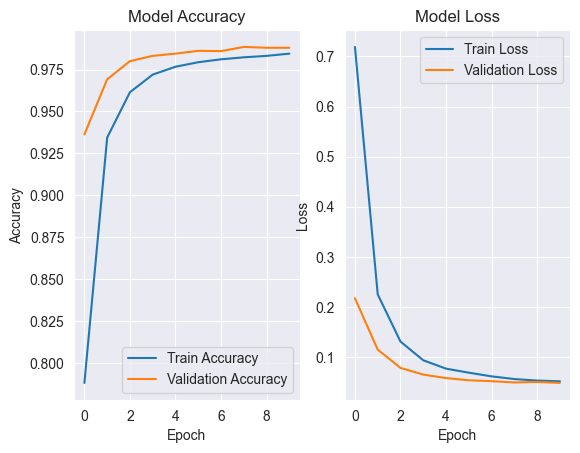

In [9]:
# Plot training & validation accuracy and loss
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()

plt.show()

## 5. Evaluate Model

In [10]:
# Load the saved model weights
model.inner.load_weights('data/model/clean_model_weights.h5')
print("Model weights loaded from disk")

# Evaluate the model
test_loss, test_acc = model.evaluate(x_test, y_test, verbose=2)
#print('\nTest accuracy', test_acc)
#print('\nTest loss', test_loss)
print(f'\nTest Loss: {test_loss:.3f}, Test Accuracy: {test_acc:.3f}')

# Making predictions on the test set
y_pred = model.predict(x_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_test, axis=1)

# Calculate the mean squared error
mse = tf.reduce_mean(tf.square(y_pred - y_test))
print(f'\nMSE: {mse:.3f}')


num_samples = 25
predictions = model.predict(x_test[:num_samples])
predicted_labels = np.argmax(predictions, axis=1)

Model weights loaded from disk
313/313 - 3s - loss: 0.0425 - accuracy: 0.9866 - 3s/epoch - 8ms/step

Test Loss: 0.043, Test Accuracy: 0.987
313/313 [==============================] - 1s 3ms/step

MSE: 0.002
1/1 [==============================] - 0s 25ms/step


In [11]:
scores = model.evaluate(x_test, y_test, verbose=0)
print("CNN Error: %.2f%%" % (100-scores[1]*100))

CNN Error: 1.34%


In [12]:
_, rmse = model.evaluate(x_train, y_train, verbose=0)
print(f'Test RMSE: {round(rmse, 3)}')

Test RMSE: 0.99


In [13]:
test_loss, test_accuracy = model.evaluate(x_test, y_test, verbose=2)
print(f'Test accuracy: {test_accuracy}\nTest loss: {test_loss}')

313/313 - 3s - loss: 0.0425 - accuracy: 0.9866 - 3s/epoch - 9ms/step
Test accuracy: 0.9865999817848206
Test loss: 0.042532362043857574


In [15]:
# Confusion Matrix and Classification Report
y_pred = model.predict(x_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_test, axis=1)

print(confusion_matrix(y_true, y_pred_classes))
print("\n")
print(classification_report(y_true, y_pred_classes))

313/313 [==============================] - 1s 3ms/step
[[ 973    0    4    1    0    0    1    0    1    0]
 [   0 1128    2    0    2    1    0    0    2    0]
 [   1    3 1023    0    1    0    0    4    0    0]
 [   0    0    2 1003    0    3    0    0    2    0]
 [   0    0    1    0  973    0    0    0    2    6]
 [   2    0    0    5    0  879    2    0    3    1]
 [   9    3    0    0    4    2  937    0    3    0]
 [   0    2   12    2    1    0    0 1006    1    4]
 [   5    1    4    1    0    1    1    2  956    3]
 [   0    3    1    2    7    2    0    4    2  988]]


              precision    recall  f1-score   support

           0       0.98      0.99      0.99       980
           1       0.99      0.99      0.99      1135
           2       0.98      0.99      0.98      1032
           3       0.99      0.99      0.99      1010
           4       0.98      0.99      0.99       982
           5       0.99      0.99      0.99       892
           6       1.00      0.98

## Adversarial Evaluation

The adversarial evaluation phase is designed to assess how well the model can identify and correctly classify images that have been deliberately perturbated to mislead it. This phase does not directly evaluate the adversarial training but rather tests the model's robustness against adversarial attacks. 

To evaluate the model's performance and robustness after it has been trained, specifically its ability to withstand adversarial attacks. This phase assesses how well the model, whether trained traditionally or with adversarial examples, can handle new, unseen adversarial inputs.

We generate new adversarial examples from the test set (which the model has not seen during training) using attack methods like **Fast Gradient Sign Method (FGSM) and PGD. The model's accuracy and loss metrics are then evaluated based on its predictions for these adversially perturbed images.

Whether the model underwent adversarial training or not, the adversarial evaluation can be performed to test its robustness. The expectation is that models trained with adversarial examples will perform better in this phase than models trained only on clean data.

In [19]:
"""
Generata adversarial examples batch by batch within a loop then trying to evaluate the model on a single batch of adversarial examples against the entire `y_test` dataset
"""

if y_test.ndim > 1:
    y_test = np.argmax(y_test, axis=1)

test_accuracy = SparseCategoricalAccuracy()

# Evaluate on clean examples
for x_batch, y_batch in tf.data.Dataset.from_tensor_slices((x_test, y_test)).batch(128):
    predictions = model.predict(x_batch)
    test_accuracy.update_state(y_batch, predictions)
    
accuracy_clean = test_accuracy.result().numpy() * 100
print(f'\nTest accuracy on clean examples: {accuracy_clean}')

# Adversarial evaluation settings
eps = 0.3
test_accuracy_fgsm = SparseCategoricalAccuracy()
test_accuracy_pgd = SparseCategoricalAccuracy()

# Evaluate on adversarial examples (FGSM and PGD)
for x_batch, y_batch in tf.data.Dataset.from_tensor_slices((x_test, y_test)).batch(128):
    # FGSM examples
    x_adv_fgsm = fast_gradient_method(model.inner, x_batch, eps, np.inf)
    predictions_fgsm = model.predict(x_adv_fgsm)
    test_accuracy_fgsm.update_state(y_batch, predictions_fgsm)
    
        
    # PGD examples
    x_adv_pdg = projected_gradient_descent(model.inner, x_batch, eps, 0.01, 40, np.inf)
    predictions_pdg = model.predict(x_adv_pdg)
    test_accuracy_pgd.update_state(y_batch, predictions_pdg)
    
accuracy_fgsm = test_accuracy_fgsm.result().numpy() * 100
accuracy_pdg = test_accuracy_pgd.result().numpy() * 100


print(f'\nTest accuracy on FGSM adversarial examples: {accuracy_fgsm}')
print(f'Test accuracy on PDG adversarial examples: {accuracy_pdg}')

accuracies = [accuracy_clean, accuracy_fgsm, accuracy_pdg]

1/1 [==============================] - 0s 11ms/step

Test accuracy on clean examples: 98.65999817848206
1/1 [==============================] - 0s 10ms/step

Test accuracy on FGSM adversarial examples: 3.9000000804662704
Test accuracy on PDG adversarial examples: 1.7799999564886093


In [20]:
"""
Creating adversarial examples for the entire test dataset and then evaluating the model on these examples
"""

if y_test.ndim > 1:
    y_test = np.argmax(y_test, axis=1)
    
model = create_stochastic_model()
model.inner.load_weights('data/model/clean_model_weights.h5')

# Generate adversarial examples for the entire test set
x_test_adv_fgsm = fast_gradient_method(model.inner, x_test, eps, np.inf, clip_min=0., clip_max=1.)
x_test_adv_pgd = projected_gradient_descent(model.inner, x_test, eps, eps_iter=0.01, nb_iter=40, norm=np.inf, clip_min=0., clip_max=1.)

# Evaluate model on the entire set of FGSM adversarial examples
loss_fgsm, accuracy_fgsm_entire = model.evaluate(x_test_adv_fgsm, tf.keras.utils.to_categorical(y_test), verbose=2)
print(f'Accuracy on FGSM adversarial examples: {accuracy_fgsm_entire*100:.2f}%')

# Evaluate the model on the entire set of PGD adversarial examples
loss_pgd, accuracy_pgd_entire = model.evaluate(x_test_adv_pgd, tf.keras.utils.to_categorical(y_test), verbose=2)
print(f'Accuracy on PGD adversarial examples: {accuracy_pgd_entire*100:.2f}%')


/opt/homebrew/lib/python3.11/site-packages/uncertainty_wizard/models/stochastic_utils/layers.py:25: UncertaintyWizardWarning: Looks like you are passing an <class 'uncertainty_wizard.models.stochastic_utils.layers.UwizBernoulliDropout'> layer.For SequentialStochastic layers, it is sufficient to pass a layer ofthe corresponding keras layer <class 'keras.src.layers.regularization.dropout.Dropout'>.We trust you that you know what you did and set up the stochastic mode correctly.Your layer will thus not be replaced, but added to the model as you provided it.
  warnings.warn(


313/313 - 3s - loss: 10.0504 - accuracy: 0.0407 - 3s/epoch - 8ms/step
Accuracy on FGSM adversarial examples: 4.07%
313/313 - 2s - loss: 19.1287 - accuracy: 0.0182 - 2s/epoch - 8ms/step
Accuracy on PGD adversarial examples: 1.82%


## 7. Plot Predictions, Confusion Matrix, Adversarial examples and Comparison between

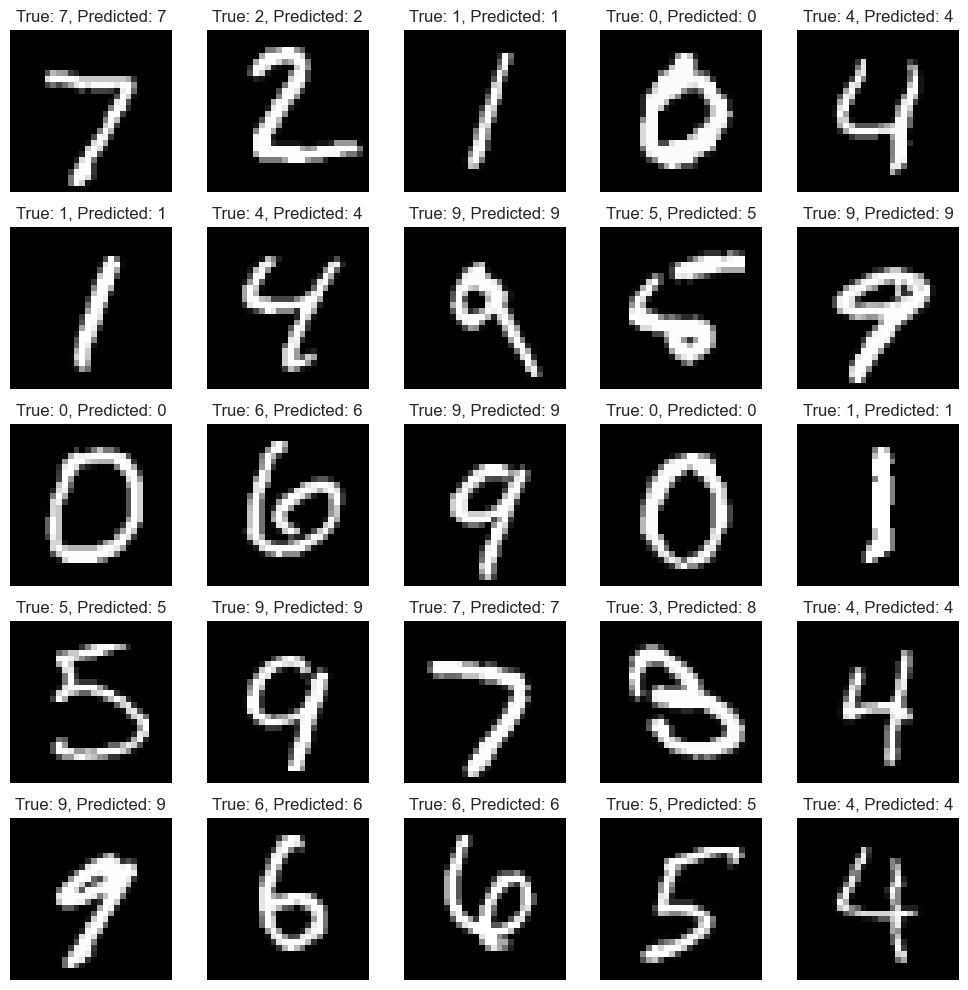

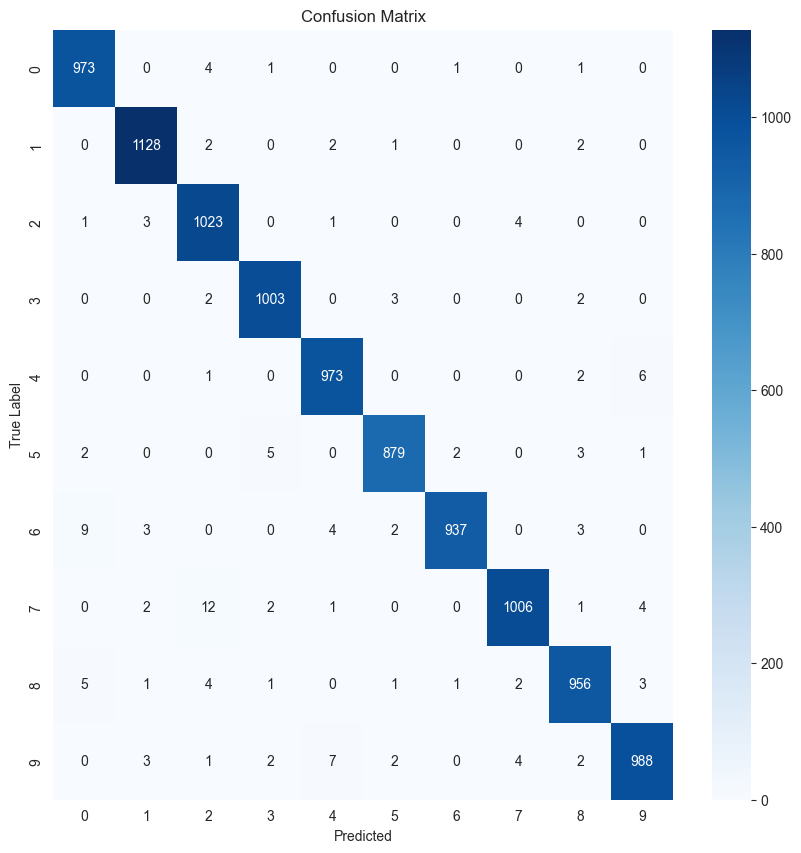

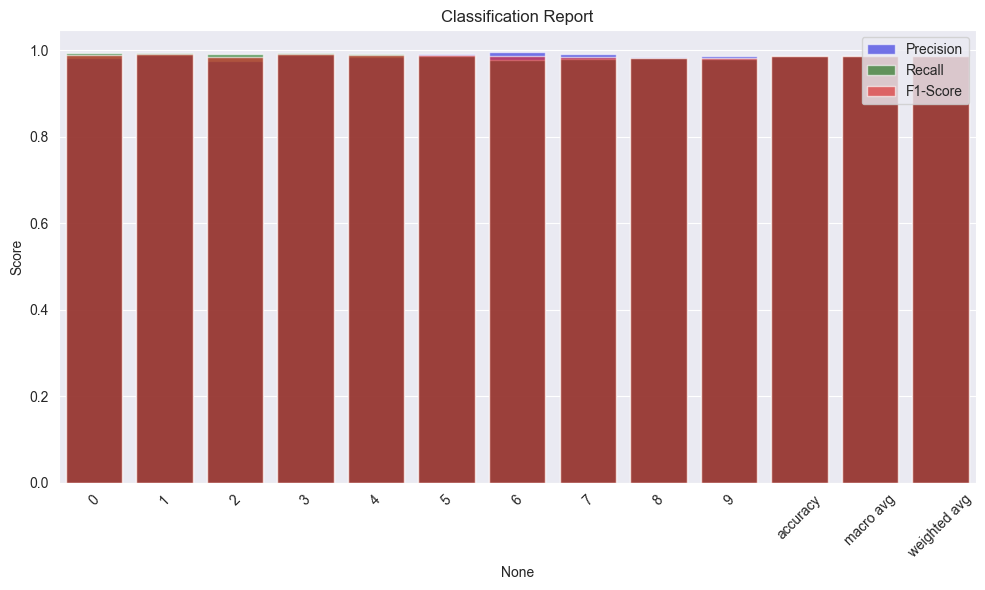

1/1 [==============================] - 0s 10ms/step


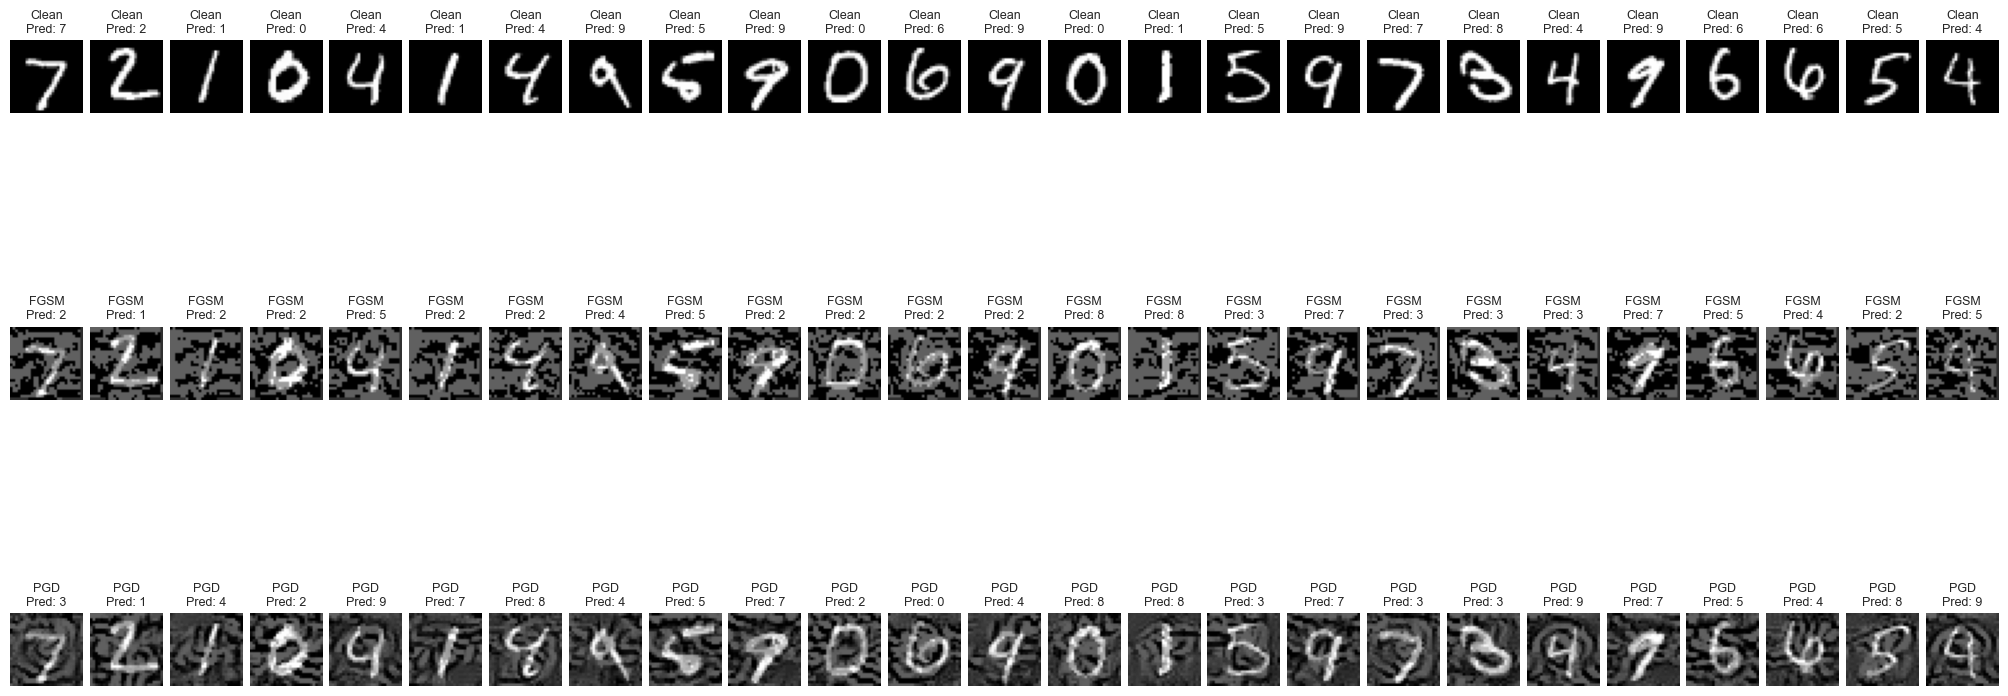

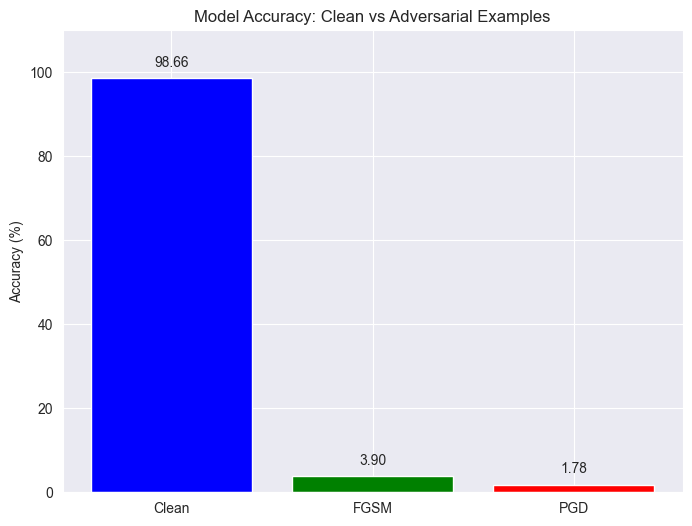

In [23]:
plt.figure(figsize=(10, 10))
for i in range(num_samples):
    plt.subplot(5, 5, i + 1)
    plt.imshow(x_test[i].reshape(28, 28), cmap='gray')
    plt.title(f'True: {y_true[i]}, Predicted: {predicted_labels[i]}')
    plt.axis('off')
plt.tight_layout()
plt.show()

# Confusion matrix
cm = confusion_matrix(y_true, y_pred_classes)
plt.figure(figsize=(10, 10))
sns.heatmap(cm, annot=True, fmt="d", cmap='Blues',
            xticklabels=[str(i) for i in range(10)],
            yticklabels=[str(i) for i in range(10)])
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True Label')
plt.show()


# Classification Report
y_pred_labels = np.argmax(y_pred, axis=1)

if y_true.ndim > 1:
    y_true_labels = np.argmax(y_true, axis=1)
else:
    y_true_labels = y_true
# Generate classification report
report = classification_report(y_true_labels, y_pred_labels, output_dict=True)

# Convert the report to a DataFrame
df_report = pd.DataFrame(report).transpose()

# Remove the 'support' 
df_report = df_report.drop(columns=['support'])

plt.figure(figsize=(10, 6))
sns.barplot(data=df_report, x=df_report.index, y='precision', label='Precision', color='b', alpha=0.6)
sns.barplot(data=df_report, x=df_report.index, y='recall', label='Recall', color='g', alpha=0.6)
sns.barplot(data=df_report, x=df_report.index, y='f1-score', label='F1-Score', color='r', alpha=0.6)

plt.xticks(rotation=45)
plt.title('Classification Report')
plt.ylabel('Score')
plt.legend(loc='upper right')
plt.tight_layout()
plt.show()

# Clean and Adversarial examples

#x_adv_fgsm = fast_gradient_method(model.inner, x_test[:num_samples], eps, np.inf)
#predictions_clean = np.argmax(model.predict(x_test[:num_samples]), axis=1)
#predictions_adv = np.argmax(model.predict(x_adv_fgsm), axis=1)

# Generate FGSM adversarial examples
x_adv_fgsm = fast_gradient_method(model.inner, x_test[:num_samples], eps, np.inf)
predictions_fgsm = np.argmax(model.predict(x_adv_fgsm), axis=1)

# Generate PGD adversarial examples
x_adv_pgd = projected_gradient_descent(model.inner, x_test[:num_samples], eps, 0.01, 40, np.inf)
predictions_pgd = np.argmax(model.predict(x_adv_pgd), axis=1)

plt.figure(figsize=(20, 10))
#plt.figure(figsize=(2 * num_samples, 6))

for i in range(num_samples):
    # Plot clean images
        plt.subplot(3, num_samples, i + 1)
        plt.imshow(x_test[i], cmap='gray')  # If x_test is not already in 28x28, reshape is needed
        plt.title(f'Clean\nPred: {np.argmax(model.predict(x_test[i:i+1]), axis=1)[0]}', fontsize=9)
        plt.axis('off')

        # Plot FGSM adversarial images
        plt.subplot(3, num_samples, num_samples + i + 1)
        plt.imshow(x_adv_fgsm[i], cmap='gray')
        plt.title(f'FGSM\nPred: {predictions_fgsm[i]}', fontsize=9)
        plt.axis('off')

        # Plot PGD adversarial images
        plt.subplot(3, num_samples, 2 * num_samples + i + 1)
        plt.imshow(x_adv_pgd[i], cmap='gray')
        plt.title(f'PGD\nPred: {predictions_pgd[i]}', fontsize=9)
        plt.axis('off')
plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=1.0)

timestamp = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
filename = f'pred_clean_vs_adv_{timestamp}.png'
plot_dir = './data/plots//evaluate'
os.makedirs(plot_dir, exist_ok=True)
plt.savefig(os.path.join(plot_dir, filename))

plt.show()


# Compare
plt.figure(figsize=(8, 6))
bar_positions = np.arange(len(accuracies))
plt.bar(bar_positions, accuracies, color=['blue', 'green', 'red'])
plt.xticks(bar_positions, labels=['Clean', 'FGSM', 'PGD'])
plt.ylabel('Accuracy (%)')
plt.title('Model Accuracy: Clean vs Adversarial Examples')
plt.ylim(0, 110)

for i, acc in enumerate(accuracies):
    plt.text(i, acc + 2, f'{acc:.2f}', ha='center', va='bottom')
    
plt.show()

## 8. Analyze the Uncertainty

In the context of neural networks, uncertainty quantification is crucial for assessing the confidence of model predictions. There are two primary types of uncertainty:

1. **Aleatoric Uncertainty**: This type of uncertainty is inherent in the data. It arises from noise or variability in the data and can be captured directly from the data itself.
2. **Epistemic Uncertainty**: This uncertainty is due to the model's lack of knowledge. It can be reduced with more data or better models and is often where dropout-based methods come into play.


In [ ]:
# Load the saved model weights 
model.inner.load_weights('data/model/model_weights.h5')
print("Model weights loaded from disk")

# Perform uncertainty quantification
quantifiers = ['pcs', 'mean_softmax']
results = model.predict_quantified(x_test,
                                    quantifier=quantifiers,
                                    batch_size=64,
                                    sample_size=32,
                                    verbose=1)


## 9. Plots for Uncertainty Analysis

1. **Prediction Confidence Score (PCS):**
    
    - PCS is a measure of the model's confidence in its predictions. For classification tasks, this often translates to how high the softmax output is for the predicted class. A higher PCS indicates higher confidence in the prediction.
2. **Mean Softmax:**
    
    - Mean Softmax is typically used in stochastic models where multiple predictions are made for the same input (as in Monte Carlo Dropout). It refers to the average of the softmax outputs across all predictions for a given input. It can be interpreted as an averaged confidence level across multiple runs.

In [ ]:
# Plot the uncertainty distribution
uncertainty_scores = results[1][1]
plt.figure(figsize=(8, 6))
plt.hist(uncertainty_scores, bins=50, alpha=0.7, color='blue')
plt.title('Distribution of Uncertainty Scores')
plt.xlabel('Uncertainty Score')
plt.ylabel('Frequency')
plt.show()

plt.show()


# Plot distribution of PCS and Mean Softmax scores
plt.figure(figsize=(10,10))
pcs_scores = results[0][1]
mean_softmax_scores = results[1][1]
plt.subplot(1, 2, 1)
plt.hist(pcs_scores, bins=50, alpha=0.7)
plt.xlabel('PCS Score')
plt.ylabel('Frequency')
plt.title('Distribution of PCS Scores')
plt.subplot(1, 2, 2)
plt.hist(mean_softmax_scores, bins=50, alpha=0.7)
plt.xlabel('Mean Softmax Score')
plt.ylabel('Frequency')
plt.title('Distribution of Mean Softmax Scores')
plt.tight_layout()
plt.show()


In [ ]:
pcs_scores = results[0][1][:num_samples]  
mean_softmax_scores = results[1][1][:num_samples]

# Plot PCS scores
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.bar(range(num_samples), pcs_scores)
plt.xlabel('Sample')
plt.ylabel('PCS Score')
plt.title('PCS Scores for Test Samples')

# Plot Mean Softmax scores
plt.subplot(1, 2, 2)
plt.bar(range(num_samples), mean_softmax_scores)
plt.xlabel('Sample')
plt.ylabel('Mean Softmax Score')
plt.title('Mean Softmax Scores for Test Samples')

plt.tight_layout()
plt.show()

In [ ]:
print(x_test.shape)
plt.figure(figsize=(10, 10))
pcs_predictions = results[0][0]
pcs_confidences = results[0][1]
mean_softmax_predictions = results[1][0]
mean_softmax_confidences = results[1][1]


plt.hist(pcs_confidences, bins=50, alpha=0.7, color='blue', label='PCS')
plt.hist(mean_softmax_confidences, bins=50, alpha=0.7, color='green', label='Mean Softmax')
plt.title('Distribution of Predictive Confidence Scores')
plt.xlabel('Predictive Confidence Score')
plt.ylabel('Frequency')
plt.legend()
plt.show()